# 0. import 라이브러리 


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm
from datetime import datetime

# 표준화 및 코사인 유사도 관련 라이브러리 
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors

# 1. 데이터 준비

## 1.1 데이터 불러오기

In [2]:
# 데이터 불러오기
recruitment_data = pd.read_csv("./data/raw_data/recruitment.csv")
company_data = pd.read_csv("./data/raw_data/company.csv")
resume_data = pd.read_csv("./data/raw_data/resume.csv")
resume_certificate_data = pd.read_csv("./data/raw_data/resume_certificate.csv")
resume_education_data = pd.read_csv("./data/raw_data/resume_education.csv")
resume_language_data = pd.read_csv("./data/raw_data/resume_language.csv")

apply_train_data = pd.read_csv("./data/raw_data/apply_train.csv")
sample_submission_data = pd.read_csv("./data/raw_data/sample_submission.csv")

## 1.2 데이터 확인 및 정제

### 1.2.1 recruitment (6,695)

<details>
<summary>  <span style="color:gold"> 상세정보 펼쳐보기 </span>  </summary>

</br>

|seq|columns|description|note|
|:--:|:--:|:--:|:--:|
|`0`|`recruitment_seq`|`공고번호`|`PK`|
|1|address_seq1|근무지주소코드1||
|2|address_seq2|근무지주소코드2||
|3|address_seq3|근무지주소코드3||
|4|career_end|요구 최대경력||
|5|career_start|요구 최소경력||
|6|check_box_keyword|모집직무코드|; 으로 구분|
|7|education|요구학위||
|8|major_task|주업무코드||
|9|qualifications|자격요건난이도||
|10|text_keyword|모집직무키워드|; 으로 구분|

</details>

In [168]:
# 데이터 확인
display(recruitment_data.tail(3))

# 결측치 확인
print(recruitment_data.isna().sum())

,recruitment_seq,address_seq1,address_seq2,address_seq3,career_end,career_start,check_box_keyword,education,major_task,qualifications,text_keyword
6692,R03252,3.0,NaN,NaN,0,0,2109,3,2,1,NaN
6693,R05130,3.0,NaN,NaN,0,0,2201;2204;2205;2707,2,2,2,NaN
6694,R04779,3.0,NaN,NaN,0,0,2101;2108;2201;2707,3,8,1,NaN


recruitment_seq         0
address_seq1            1
address_seq2         6595
address_seq3         6686
career_end              0
career_start            0
check_box_keyword       0
education               0
major_task              0
qualifications          0
text_keyword         5988
dtype: int64


In [169]:
# address_seq 컬럼 중 NaN를 0.0로 변경
recruitment_data.address_seq1 = recruitment_data.address_seq1.replace(np.NAN, 0.0)
recruitment_data.address_seq2 = recruitment_data.address_seq2.replace(np.NAN, 0.0)
recruitment_data.address_seq3 = recruitment_data.address_seq3.replace(np.NAN, 0.0)

# text_keyword 컬럼 중 NaN를 '없음'로 변경
recruitment_data.text_keyword = recruitment_data.text_keyword.replace(np.NAN, '없음')

# 결측치 재확인
print(recruitment_data.isna().sum())

recruitment_seq      0
address_seq1         0
address_seq2         0
address_seq3         0
career_end           0
career_start         0
check_box_keyword    0
education            0
major_task           0
qualifications       0
text_keyword         0
dtype: int64


### 1.2.2 company (2,377)

<details>
<summary>  <span style="color:gold"> 상세정보 펼쳐보기 </span>  </summary>

</br>

|seq|columns|description|note|
|:--:|:--:|:--:|:--:|
|`0`|`recruitment_seq`|`공고번호`|`FK`|
|1|company_type_seq|회사유형코드||
|2|supply_kind|주업종코드||
|3|employee|종업원수||
<details>

In [170]:
# 데이터 확인
display(company_data.tail(3))

# 결측치 확인
print(company_data.isna().sum())

,recruitment_seq,company_type_seq,supply_kind,employee
2374,R04028,4,402,525
2375,R06508,2,402,70
2376,R00604,5,402,300


recruitment_seq     0
company_type_seq    0
supply_kind         0
employee            0
dtype: int64


### 1.2.3 resume (8,482)

<details>
<summary>  <span style="color:gold"> 상세정보 펼쳐보기 </span>  </summary>

</br>

|seq|columns|description|note|
|:--:|:--:|:--:|:--:|
|`0`|`resume_seq`|`이력서번호`|`PK`|
|1|reg_data|이력서등록일||
|2|updated_data|이력서수정일||
|3|degree|최종학력||
|4|graduate_data|졸업년도||
|5|hope_salary|희망연봉||
|6|last_salary|최종연봉||
|7|text_keyword|직무키워드|; 으로 구분|
|8|job_code_seq1|희망직무1||
|9|job_code_seq2|희망직무2||
|10|job_code_seq3|희망직무3||
|11|career_month|경력월||
|12|career_job_code|경력직무|; 으로 구분|
</details>

In [171]:
# 데이터 확인
display(resume_data.tail(3))

# 결측치 확인
print(resume_data.isna().sum())

,resume_seq,reg_date,updated_date,degree,graduate_date,hope_salary,last_salary,text_keyword,job_code_seq1,job_code_seq2,job_code_seq3,career_month,career_job_code
8479,U01468,2019-02-26,2020-06-23,4,2008,0.0,0.0,상품기획MD;우븐디자인,디자인,NaN,NaN,0,섬유;봉제;가방;의류
8480,U05315,2020-03-27,2020-12-21,4,2016,0.0,0.0,여성복디자인;우븐디자인;다이마루디자인,재료·화학·섬유·의복,NaN,NaN,18,디자인;CAD;설계
8481,U01277,2020-09-22,2020-09-22,4,2009,2100.0,1000.0,상품기획;머천다이저,재료·화학·섬유·의복,NaN,NaN,3,섬유;봉제;가방;의류


resume_seq            0
reg_date              0
updated_date          0
degree                0
graduate_date         0
hope_salary           0
last_salary           0
text_keyword        195
job_code_seq1         0
job_code_seq2      7982
job_code_seq3      8295
career_month          0
career_job_code     758
dtype: int64


In [172]:
# text_keyword 컬럼 중 NaN를 '없음'로 변경
resume_data.text_keyword = resume_data.text_keyword.replace(np.NAN, '없음')

# job_code_seq 컬럼 중 NaN를 '없음'로 변경
resume_data.job_code_seq2 = resume_data.job_code_seq2.replace(np.NAN, '없음')
resume_data.job_code_seq3 = resume_data.job_code_seq3.replace(np.NAN, '없음')

# career_job_code 컬럼 중 NaN를 '없음'로 변경
resume_data.career_job_code = resume_data.career_job_code.replace(np.NAN, '없음')


# 결측치 재확인
print(recruitment_data.isna().sum())

recruitment_seq      0
address_seq1         0
address_seq2         0
address_seq3         0
career_end           0
career_start         0
check_box_keyword    0
education            0
major_task           0
qualifications       0
text_keyword         0
dtype: int64


### 1.2.4 resume_certificate (12,975)

<details>
<summary>  <span style="color:gold"> 상세정보 펼쳐보기 </span>  </summary>

</br>

|seq|columns|description|note|
|:--:|:--:|:--:|:--:|
|`0`|`resume_seq`|`이력서번호`|`FK`|
|1|certificate_contents|자격증명||
</details>

In [173]:
# 데이터 확인
display(resume_certificate_data.tail(3))

# 결측치 확인
print(resume_certificate_data.isna().sum())

,resume_seq,certificate_contents
12972,U03248,수치제어밀링기능사
12973,U08157,주산2급
12974,U02889,유통관리사 2급


resume_seq              0
certificate_contents    4
dtype: int64


In [174]:
# certificate_contents 컬럼 중 NaN를 '없음'로 변경
resume_certificate_data.certificate_contents = resume_certificate_data.certificate_contents.replace(np.NAN, '확인불가')


# 결측치 재확인
print(resume_certificate_data.isna().sum())

resume_seq              0
certificate_contents    0
dtype: int64


### 1.2.5 resume_education (8,482)

<details>
<summary>  <span style="color:gold"> 상세정보 펼쳐보기 </span>  </summary>

</br>

|seq|columns|description|note|
|:--:|:--:|:--:|:--:|
|`0`|`resume_seq`|`이력서번호`|`FK`|
|1|hischool_type_seq|고등학교유형코드||
|2|hischool_special_type|특수고등학교분류||
|3|hischool_nation|고등학교공립/사립구분||
|4|hischool_gender|고등학교남녀/공학구분||
|5|hischool_location_seq|고등학교지역코드||
|6|univ_type_seq1|최종대학(원)유형코드1||
|7|univ_type_seq2|최종대학(원)유형코드2||
|8|univ_tranfer|최종대학(원)편입여부|편입: 1|
|9|univ_location|최종대학(원)지역코드|
|10|univ_major|최종대학(원)전공||
|11|univ_sub_major|최종대학(원)부전공||
|12|univ_major_type|최종대학(원)주전공계열코드||
|13|univ_score|최종대학(원)평균평점||
</details>

In [175]:
# 데이터 확인
display(resume_education_data.tail(3))

# 결측치 확인
print(resume_education_data.isna().sum())

,resume_seq,hischool_type_seq,hischool_special_type,hischool_nation,hischool_gender,hischool_location_seq,univ_type_seq1,univ_type_seq2,univ_transfer,univ_location,univ_major,univ_sub_major,univ_major_type,univ_score
8479,U04109,21,일반고,공립,남여공학,5,0,0,0,0,NaN,NaN,9,80.0
8480,U01863,21,일반고,사립,여자학교,15,3,5,0,15,의류학과생활과학계열,NaN,9,80.0
8481,U05884,0,기타,기타,기타,0,5,5,0,11,NaN,NaN,9,90.0


resume_seq                  0
hischool_type_seq           0
hischool_special_type       0
hischool_nation             0
hischool_gender             0
hischool_location_seq       0
univ_type_seq1              0
univ_type_seq2              0
univ_transfer               0
univ_location               0
univ_major               6687
univ_sub_major           8066
univ_major_type             0
univ_score                  0
dtype: int64


In [176]:
# certificate_contents 컬럼 중 NaN를 '없음'로 변경
resume_education_data.univ_major  = resume_education_data.univ_major .replace(np.NAN, '없음')

# certificate_contents 컬럼 중 NaN를 '없음'로 변경
resume_education_data.univ_sub_major  = resume_education_data.univ_sub_major.replace(np.NAN, '없음')


# 결측치 재확인
print(resume_education_data.isna().sum())

resume_seq               0
hischool_type_seq        0
hischool_special_type    0
hischool_nation          0
hischool_gender          0
hischool_location_seq    0
univ_type_seq1           0
univ_type_seq2           0
univ_transfer            0
univ_location            0
univ_major               0
univ_sub_major           0
univ_major_type          0
univ_score               0
dtype: int64


### 1.2.6 resume_language (869)

<details>
<summary>  <span style="color:gold"> 상세정보 펼쳐보기 </span>  </summary>

</br>

|seq|columns|description|note|
|:--:|:--:|:--:|:--:|
|`0`|`resume_seq`|`이력서번호`|`FK`|
|1|language|외국어코드||
|2|exam_name|공인시험코드||
|3|score|점수||
</details>

In [177]:
# 데이터 확인
display(resume_language_data.tail(3))

# 결측치 확인
print(resume_language_data.isna().sum())

,resume_seq,language,exam_name,score
866,U05922,2,2,500.00
867,U03827,2,4,883.84
868,U04680,2,4,666.67


resume_seq    0
language      0
exam_name     0
score         0
dtype: int64


### 1.2.7 apply_train (57,946)

<details>
<summary>  <span style="color:gold"> 상세정보 펼쳐보기 </span>  </summary>

</br>

|seq|columns|description|note|
|:--:|:--:|:--:|:--:|
|`0`|`resume_seq`|`이력서번호`|`FK`|
|<span style="color:yellow">1|<span style="color:yellow">recruitment_seq|<span style="color:yellow">공고번호|<span style="color:yellow">TARGET(FK)</span>|

</deatils>

In [178]:
# 데이터 확인
display(apply_train_data.tail(3))

# 결측치 확인
print(apply_train_data.isna().sum())

,resume_seq,recruitment_seq
57943,U08238,R01342
57944,U01296,R06363
57945,U05748,R03090


resume_seq         0
recruitment_seq    0
dtype: int64


### 1.2.8 sample_submission (42,410)

> 사용자별로 5개씩 공고ID추천리스트 생성

<details>
<summary>  <span style="color:gold"> 상세정보 펼쳐보기 </span>  </summary>

</br>

|seq|columns|description|note|
|:--:|:--:|:--:|:--:|
|`0`|`resume_seq`|`이력서번호`|`FK`|
|<span style="color:yellow">1|<span style="color:yellow">recruitment_seq|<span style="color:yellow">공고번호|<span style="color:yellow">TARGET(FK)</span>|
</details>

In [179]:
# 데이터 확인
display(sample_submission_data.tail(3))

# 결측치 확인
print(sample_submission_data.isna().sum())

,resume_seq,recruitment_seq
42407,U08482,R01931
42408,U08482,R01607
42409,U08482,R06059


resume_seq         0
recruitment_seq    0
dtype: int64


## 1.3 데이터 전처리

### 1.3.1 채용 공고 관련 데이터 중 사용할 데이터 추출

<details>
<summary>  <span style="color:gold"> 상세정보 펼쳐보기 </span>  </summary>

</br>

|seq|columns|description|example|note|
|:--:|:--:|:--:|:--:|:--:|
|0|<span style="color:orange">recruitment_seq|<span style="color:orange">공고번호|R02444|PK|
|1|<span style="color:orange">address_seq1|<span style="color:orange">근무지주소코드1|3.0||
|2|<span style="color:orange">address_seq2|<span style="color:orange">근무지주소코드2|20.0||
|3|address_seq3|근무지주소코드3|20.0|기입된 데이터는 9개 뿐으로 사용 X|
|4|career_end|요구 최대경력|0|모든 값이 0|
|5|career_start|요구 최소경력|0|모든 값이 0|
|6|<span style="color:orange">check_box_keyword|<span style="color:orange">모집직무코드|2507;2707;2810|; 으로 구분|
|7|<span style="color:orange">education|<span style="color:orange">요구학위|4||
|8|<span style="color:orange">major_task|<span style="color:orange">주업무코드|8||
|9|<span style="color:orange">qualifications|<span style="color:orange">자격요건난이도|1||
|10|text_keyword|모집직무키워드|MD;기획MD;여성복;캐주얼|; 으로 구분 / 707개의 데이터가 있지만 확인 결과 'check_box_keyword'컬럼이 더 객관적 분류 가능|
|11|<span style="color:orange">company_type_seq|<span style="color:orange">회사유형코드|2||
|12|<span style="color:orange">supply_kind|<span style="color:orange">주업종코드|514||
|13|<span style="color:orange">employee|<span style="color:orange">종업원수|20|회사 규모에 따라 4단계로 구분 / 0: 정보없음, 300명 미만: 중소기업, 300~1000명: 중견기업, 1000명 이상:대기업|
</details>

In [180]:
# 필요 데이터 추출
rec_data = pd.merge(recruitment_data.drop(['address_seq3','career_end','career_start','text_keyword'], axis='columns'), company_data, how='outer', on='recruitment_seq')
display(rec_data.tail(3))

,recruitment_seq,address_seq1,address_seq2,check_box_keyword,education,major_task,qualifications,company_type_seq,supply_kind,employee
6692,R03252,3.0,0.0,2109,3,2,1,4.0,402.0,525.0
6693,R05130,3.0,0.0,2201;2204;2205;2707,2,2,2,2.0,402.0,40.0
6694,R04779,3.0,0.0,2101;2108;2201;2707,3,8,1,2.0,402.0,41.0


In [182]:
# 결측치가 있는 컬럼명 출력
print(', '.join([col for col in rec_data.columns if rec_data[col].isna().sum() != 0]))

company_type_seq, supply_kind, employee


In [183]:
# 데이터 정제 및 수정
rec_data.company_type_seq = rec_data.company_type_seq.replace(np.NAN, 0)
rec_data.supply_kind = rec_data.supply_kind.replace(np.NAN, 0)
rec_data.employee = rec_data.employee.replace(np.NAN, 0)

# 결측치 재확인
print(rec_data.isna().sum())

recruitment_seq      0
address_seq1         0
address_seq2         0
check_box_keyword    0
education            0
major_task           0
qualifications       0
company_type_seq     0
supply_kind          0
employee             0
dtype: int64


In [186]:
# 기업 규모 분류
rec_data['company_scale'] = 0

for i in range(len(rec_data)):
    x = rec_data.loc[i]['employee']
    if x > 999:
        rec_data.loc[i,'company_scale'] = 3
    elif x > 299:
        rec_data.loc[i,'company_scale'] = 2
    elif x > 0:
        rec_data.loc[i,'company_scale'] = 1
    else:
        rec_data.loc[i,'company_scale'] = 0

In [188]:
# employee 컬럼 제거
rec_data.drop(['employee'], axis='columns', inplace=True)
rec_data

,recruitment_seq,address_seq1,address_seq2,check_box_keyword,education,major_task,qualifications,company_type_seq,supply_kind,company_scale
0,R02264,3.0,0.0,2507;2707;2810,4,8,1,5.0,402.0,2
1,R06317,3.0,0.0,2204;2205;2707,3,2,1,0.0,0.0,0
2,R04017,3.0,0.0,2101;2108;2201;2707,3,2,1,0.0,0.0,0
3,R02865,3.0,0.0,2201;2204;2205;2707,2,2,1,0.0,0.0,0
4,R04890,3.0,0.0,2201;2204;2205;2707,2,2,2,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...
6690,R03678,3.0,0.0,2101;2108;2201;2204;2205;2707,3,2,1,0.0,0.0,0
6691,R04593,3.0,0.0,2201;2204;2205;2707,4,2,1,0.0,0.0,0
6692,R03252,3.0,0.0,2109,3,2,1,4.0,402.0,2
6693,R05130,3.0,0.0,2201;2204;2205;2707,2,2,2,2.0,402.0,1


In [190]:
# 완성 데이터 저장
# rec_data.to_csv('./data/pre-processed_data/rec_data.csv', encoding='utf-8-sig')

### 1.3.2 이력서 관련 데이터 중 사용할 데이터 추출

<details>
<summary> <span style="color:gold"> 상세정보 펼쳐보기 </span> </summary>

</br>

|seq|columns|description|example|note|
|:--:|:--:|:--:|:--:|:--:|
|0|<span style="color:orange">resume_seq|<span style="color:orange">이력서번호|U01468|PK|
|1|reg_data|이력서등록일|2019-02-26||
|2|updated_data|이력서수정일|2020-06-23||
|3|<span style="color:orange">degree|<span style="color:orange">최종학력|4||
|4|graduate_data|졸업년도|2008||
|5|<span style="color:orange">hope_salary|<span style="color:orange">희망연봉|2100.0||
|6|last_salary|최종연봉|1000.0||
|7|<span style="color:orange">text_keyword|<span style="color:orange">직무키워드|상품기획MD;우븐디자인|; 으로 구분|
|8|<span style="color:green">job_code_seq1|<span style="color:green">희망직무1|경영·기획·회계·사무|희망직무 1~3은 순서에 상관없음으로 확인|
|9|<span style="color:green">job_code_seq2|<span style="color:green">희망직무2|재료·화학·섬유·의복|>> 희망직무1~3 를 기존의 13개의 직무를 바탕으로 새로운 분류 코드 생성|
|10|<span style="color:green">job_code_seq3|<span style="color:green">희망직무3|영업·판매·TM|>> '기타 직종'과 'NaN'은 '기타 직종' / '여행사'는 '관광'으로 통합|
|11|<span style="color:orange">career_month|<span style="color:orange">경력월|120|1년 단위로 그룹화|
|12|<span style="color:orange">career_job_code|<span style="color:orange">경력직무|섬유;봉제;가방;의류|; 으로 구분|
|13|<span style="color:orange">certificate_contents|<span style="color:orange">자격증명|주산2급|총 1787 종, 1인 기준 최대 10개 보유, 가나다순 자격증 리스트 작성|
|14|hischool_type_seq|고등학교유형코드|21|사용 X (최종학력으로만 구분 예정)|
|15|hischool_special_type|특수고등학교분류|일반고|사용 X (최종학력으로만 구분 예정)|
|16|hischool_nation|고등학교공립/사립구분|사립|사용 X (최종학력으로만 구분 예정)|
|17|hischool_gender|고등학교남녀/공학구분|여자학교|사용 X (최종학력으로만 구분 예정)|
|18|hischool_location_seq|고등학교지역코드|15|사용 X (최종학력으로만 구분 예정)|
|19|<span style="color:orange">univ_type_seq1|<span style="color:orange">최종대학(원)유형코드1|3|6종류|
|20|<span style="color:orange">univ_type_seq2|<span style="color:orange">최종대학(원)유형코드2|5|10종류|
|21|univ_tranfer|최종대학(원)편입여부|0|편입: 1|
|22|univ_location|최종대학(원)지역코드|15||
|23|univ_major|최종대학(원)전공|의류학과생활과학계열|주전공계열코드 사용|
|24|univ_sub_major|최종대학(원)부전공|의상디자인교육학|8482개의 데이터 중 416개의 데이터가 있지만, 전부 개별로 나뉘어져 사용 X|
|25|<span style="color:orange">univ_major_type|<span style="color:orange">최종대학(원)주전공계열코드|9||
|26|<span style="color:orange">univ_score|<span style="color:orange">최종대학(원)평균평점|80.0|0점, 1~10점, ... ,91~99점, 100점으로 그룹화|
|27|<span style="color:green">language|<span style="color:green">외국어코드|2|총 5종류|
|28|<span style="color:green">exam_name|<span style="color:green">공인시험코드|4|총 15종류|
|29|<span style="color:green">score|<span style="color:green">점수|883.84|가산점 형식으로 모든 외국어 점수 총합 계산; 점수에 따라 7개 등급 분류(상대평가)|

</details>

#### 1.3.2.1 resume_data 중 사용할 데이터 추출

기존의 희망직무 코드 중 13개를 선정<br>

> 'IT·게임', '건설·기계·전기·전자','경영·기획·회계·사무', '관광', '기술·과학·산업', '디자인', '문화·예술·신문·방송', '영업·판매·TM', '재료·화학·섬유·의복', '전문·교육·자격', '통신·모바일', '기타 직종', '없음'

<br>
<span style="color:gold">희망직무 1 </span><br> 
**'IT·게임', '건설·기계·전기·전자', '경영·기획·회계·사무', '기타 직종', '디자인', '문화·예술·신문·방송', '영업·판매·TM', '재료·화학·섬유·의복', '전문·교육·자격'<br><br>
<span style="color:gold">희망직무 2 </span><br>  'IT·게임', <span style="color:pink">'NaN' >> '없음'</span>, '건설·기계·전기·전자', '경영·기획·회계·사무', '기술·과학·산업', '기타 직종', '디자인', '문화·예술·신문·방송', <span style="color:pink">'여행사' >> '관광'</span>, '영업·판매·TM', '재료·화학·섬유·의복', '전문·교육·자격'<br><br>
<span style="color:gold">희망직무 3 </span><br>  'IT·게임', <span style="color:pink">'NaN' >> '없음'</span>, '건설·기계·전기·전자', '관광', '기술·과학·산업', '기타 직종', '디자인', '문화·예술·신문·방송', '영업·판매·TM', '재료·화학·섬유·의복', '전문·교육·자격', '통신·모바일'

In [191]:
# 희망직무 통합 코드 만들기
## resume_data 중 사용할 컬럼 가져오기
resume_temp = resume_data[['resume_seq','degree','hope_salary','text_keyword','job_code_seq1','job_code_seq2','job_code_seq3','career_month','career_job_code']]

## 통합 12개의 희망직무 코드 중 선택한 직무 코드를 하나로 묶어주기
resume_temp = resume_temp.replace({'job_code_seq2':'여행사'},'관광')
new_job_code_seq = {'IT·게임':'a', '건설·기계·전기·전자':'b','경영·기획·회계·사무':'c', '관광':'d', '기술·과학·산업':'e', '디자인':'f', '문화·예술·신문·방송':'g', '영업·판매·TM':'h', '재료·화학·섬유·의복':'i', '전문·교육·자격':'j', '통신·모바일':'k', '기타 직종':'l', '없음':''}

resume_temp['job_code_seq'] = ''
for i in range(len(resume_temp)):
    resume_temp.loc[i,'job_code_seq'] = ''.join(sorted(set([new_job_code_seq[resume_temp.loc[i]['job_code_seq1']], new_job_code_seq[resume_temp.loc[i]['job_code_seq2']],new_job_code_seq[resume_temp.loc[i]['job_code_seq3']]])))

## 기존의 희망직무1~3 제거
resume_temp = resume_temp.drop(['job_code_seq1','job_code_seq2','job_code_seq3'], axis='columns')



# 1000(만원)단위로 희망 연봉분류 
resume_temp['hope_salary_group'] = 0
for i in range(len(resume_temp)):
    resume_temp.loc[i,'hope_salary_group'] = int(resume_temp.loc[i]['hope_salary'] // 1000)

## 기존의 희망 연봉 컬럼 제거
resume_temp = resume_temp.drop(['hope_salary'], axis='columns')

# 데이터 확인
display(resume_temp.tail(5))

,resume_seq,degree,text_keyword,career_month,career_job_code,job_code_seq,hope_salary_group
8477,U04890,5,상품기획;생산;글로벌소싱;남성복;여성복,204,섬유;봉제;가방;의류,i,0
8478,U05910,4,소재;기획MD;남성복;온라인MD;디자이너,12,섬유;봉제;가방;의류,i,2
8479,U01468,4,상품기획MD;우븐디자인,0,섬유;봉제;가방;의류,f,0
8480,U05315,4,여성복디자인;우븐디자인;다이마루디자인,18,디자인;CAD;설계,i,0
8481,U01277,4,상품기획;머천다이저,3,섬유;봉제;가방;의류,i,2


In [192]:
# 이력서 통합 데이터 (res_data)로 병합
res_data = resume_temp
res_data.tail(4)

,resume_seq,degree,text_keyword,career_month,career_job_code,job_code_seq,hope_salary_group
8478,U05910,4,소재;기획MD;남성복;온라인MD;디자이너,12,섬유;봉제;가방;의류,i,2
8479,U01468,4,상품기획MD;우븐디자인,0,섬유;봉제;가방;의류,f,0
8480,U05315,4,여성복디자인;우븐디자인;다이마루디자인,18,디자인;CAD;설계,i,0
8481,U01277,4,상품기획;머천다이저,3,섬유;봉제;가방;의류,i,2


#### 1.3.2.2 resume_education_data 중 사용할 데이터 추출

In [193]:
# resume_education_data 중 필요한 컬럼 가져오기
resume_temp = resume_education_data[['resume_seq','univ_type_seq1','univ_type_seq2','univ_major_type','univ_score']]

# univ_score 그룹화
resume_temp['univ_score_group'] = 100
for i in range(len(resume_temp)):
    x = resume_temp.loc[i]['univ_score']
    if x == 0:
        resume_temp.loc[i,'univ_score_group'] = 0 
    else:
        resume_temp.loc[i,'univ_score_group'] = 1+(x-1)//10


## 기존의 점수 컬럼 제거
resume_temp = resume_temp.drop(['univ_score'], axis='columns')

# 데이터 확인
display(resume_temp.tail(5))

C:\Users\kimss\AppData\Local\Temp\ipykernel_17128\978520105.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  resume_temp['univ_score_group'] = 100


,resume_seq,univ_type_seq1,univ_type_seq2,univ_major_type,univ_score_group
8477,U06326,5,5,10,7
8478,U07284,5,5,3,7
8479,U04109,0,0,9,8
8480,U01863,3,5,9,8
8481,U05884,5,5,9,9


In [194]:
# 이력서 통합 데이터 (res_data)로 병합
res_data = pd.merge(res_data, resume_temp, how='outer', on='resume_seq')
res_data.tail(4)

,resume_seq,degree,text_keyword,career_month,career_job_code,job_code_seq,hope_salary_group,univ_type_seq1,univ_type_seq2,univ_major_type,univ_score_group
8478,U05910,4,소재;기획MD;남성복;온라인MD;디자이너,12,섬유;봉제;가방;의류,i,2,5,5,19,8
8479,U01468,4,상품기획MD;우븐디자인,0,섬유;봉제;가방;의류,f,0,5,5,9,8
8480,U05315,4,여성복디자인;우븐디자인;다이마루디자인,18,디자인;CAD;설계,i,0,5,5,9,8
8481,U01277,4,상품기획;머천다이저,3,섬유;봉제;가방;의류,i,2,5,5,5,8


#### 1.3.2.3 resume_certificate_data 데이터 중 사용할 데이터 추출

> 많이 취득하는 자격증 명칭 통합

<details>
<summary> <span style="color:gold"> 상세정보 펼쳐보기 </span> </summary>

</br>

|번호|자격증|비고|
|--|--|--|
|1|자동차 운전면허 1종 보통|44개 >> 1개|
|2|자동차 운전면허 1종 대형|9개 >> 1개|
|3|자동차 운전면허 2종 보통|27개 >> 1개|
|4|자동차 운전면허 2종 소형|6개 >> 1개|
|5|MOS WORD|모스, 등 포함, (CORE, EXPERT 통합)|
|6|MOS EXCEL|마이크로소프트 엑셀 등 포함, (CORE, EXPERT 통합)|
|7|MOS POWERPOINT|MOS 파워포인트, MOS POWER POINT 등 포함|
|8|MOS ACCESS|CORE, EXPERT 통합|
|9|MOS OUTLOOK||
|10|MOS MASTER|MOSMASTER,모스마스터 등 포함, 세부 취득 기준은 제거|
|11|MCAS|'MCAS MASTER 2007'로 형식 맞춰주기|
|12|MOUS MASTER||
|13|MOUS WORD||
|14|MOUS POWERPOINT||
|15|MOUS EXCEL||
|16|워드프로세서|급수 구분 X|
|17|컴퓨터활용능력|컴활, 컴퓨터활용 등 포함, (1, 2급 통합)|
|18|한자급수 자격시험|한자 관련 자격증 보유 여부|
|19|ITQ 정보기술자격|문서작업 / 인터넷 으로만 구분|
|20|한국사능력검정시험|한국사 관련 자격증 보유 여부|
</details>

In [195]:
resume_temp = resume_certificate_data

# 자격증 명칭 통일
resume_temp['std_certificate_contents'] = ''


## 자동차 운전면허
resume_temp.loc[(resume_temp.certificate_contents.str.contains('1종')) & (resume_temp.certificate_contents.str.contains('보')) , 'std_certificate_contents'] = '자동차 운전면허 1종 보통'
resume_temp.loc[(resume_temp.certificate_contents.str.contains('1종')) & (resume_temp.certificate_contents.str.contains('대')) , 'std_certificate_contents'] = '자동차 운전면허 1종 대형'
resume_temp.loc[((resume_temp.certificate_contents.str.contains('2종')) & (resume_temp.certificate_contents.str.contains('보')) | (resume_temp.certificate_contents.str.contains('2종운전'))) , 'std_certificate_contents'] = '자동차 운전면허 2종 보통'
resume_temp.loc[(resume_temp.certificate_contents.str.contains('2종')) & (resume_temp.certificate_contents.str.contains('소')) , 'std_certificate_contents'] = '자동차 운전면허 2종 소형'

## MCAS
for i in [6718, 9402]:
    resume_temp.std_certificate_contents[i] = 'MCAS MASTER 2007'

## MOS
resume_temp.loc[((resume_temp.certificate_contents.str.contains('MOS') | resume_temp.certificate_contents.str.contains('모스')) & (resume_temp.certificate_contents.str.contains('MASTER') | resume_temp.certificate_contents.str.contains('마스터'))) , 'std_certificate_contents'] = 'MOS MASTER'
resume_temp.loc[(resume_temp.std_certificate_contents == '') & (resume_temp.certificate_contents == '워드') | (resume_temp.certificate_contents == '파워포인트') | (resume_temp.certificate_contents == '파워 포인트') | (resume_temp.certificate_contents == '엑셀') | (resume_temp.certificate_contents == '엑서스'), 'std_certificate_contents'] = 'MOS MASTER'
### MOS MASTER 특이사항 추가
for i in [634, 2416, 2712, 3638, 3713, 5273, 6778, 7235, 8001, 11088, 11697, 12599, 12955, 11777, 12724]:
    resume_temp.std_certificate_contents[i] = 'MOS MASTER'
resume_temp.loc[((resume_temp.std_certificate_contents == '') & (resume_temp.certificate_contents.str.contains('MOS') | resume_temp.certificate_contents.str.contains('모스')) & (resume_temp.certificate_contents.str.contains('WORD') | resume_temp.certificate_contents.str.contains('워드'))) , 'std_certificate_contents'] = 'MOS WORD'
resume_temp.loc[((resume_temp.std_certificate_contents == '') & (resume_temp.certificate_contents.str.contains('MOS') | resume_temp.certificate_contents.str.contains('모스')) & (resume_temp.certificate_contents.str.contains('EXCEL') | resume_temp.certificate_contents.str.contains('엑셀'))) , 'std_certificate_contents'] = 'MOS EXCEL'
resume_temp.loc[((resume_temp.std_certificate_contents == '') & (resume_temp.certificate_contents.str.contains('MOS') | resume_temp.certificate_contents.str.contains('모스')) & (resume_temp.certificate_contents.str.contains('ACCESS'))) , 'std_certificate_contents'] = 'MOS ACCESS'
resume_temp.loc[((resume_temp.std_certificate_contents == '') & (resume_temp.certificate_contents.str.contains('MOS') | resume_temp.certificate_contents.str.contains('모스')) & (resume_temp.certificate_contents.str.contains('OUTLOOK'))) , 'std_certificate_contents'] = 'MOS OUTLOOK'

## MOUS
resume_temp.loc[(resume_temp.std_certificate_contents == '') & (resume_temp.certificate_contents == 'MOUS(MICROSOFT OFFICE USER SPECIALIST)') | (resume_temp.certificate_contents == 'MOUS EXPERT MASTER') | (resume_temp.certificate_contents == 'MOUS') | (resume_temp.certificate_contents == 'MOUS EXPERT') | (resume_temp.certificate_contents == 'MOUS MASTER'), 'std_certificate_contents'] = 'MOUS MASTER'
resume_temp.loc[(resume_temp.std_certificate_contents == '') & (resume_temp.certificate_contents == 'MOUS 파워포인트') | (resume_temp.certificate_contents == 'MOUS POWERPOINT 2002 CORE'), 'std_certificate_contents'] = 'MOUS POWERPOINT'
resume_temp.loc[(resume_temp.std_certificate_contents == '') & (resume_temp.certificate_contents == 'MOUS 워드') | (resume_temp.certificate_contents == 'MOUS WORD 2003 EXPERT'), 'std_certificate_contents'] = 'MOUS WORD'
resume_temp.loc[(resume_temp.std_certificate_contents == '') & (resume_temp.certificate_contents == 'MOUS 엑셀') | (resume_temp.certificate_contents == 'MOUS EXCEL 2003 EXPERT'), 'std_certificate_contents'] = 'MOUS EXCEL'

## 워드프로세서
resume_temp.loc[(resume_temp.std_certificate_contents == '') & ~(resume_temp.certificate_contents.str.contains('DIAT')) & ~(resume_temp.certificate_contents.str.contains('ICDL')) & (resume_temp.certificate_contents.str.contains('급') | resume_temp.certificate_contents.str.contains('프로세')) & resume_temp.certificate_contents.str.contains('워드'), 'std_certificate_contents'] = '워드프로세스'

## 컴퓨터활용능력
resume_temp.loc[(resume_temp.std_certificate_contents == '')& ~(resume_temp.certificate_contents.str.contains('ICDL')) & (resume_temp.certificate_contents.str.contains('컴활') | resume_temp.certificate_contents.str.contains('컴퓨터활') | resume_temp.certificate_contents.str.contains('컴퓨터 활용')), 'std_certificate_contents'] = '컴퓨터활용능력'

## 한자급수
resume_temp.loc[(resume_temp.std_certificate_contents == '') & (resume_temp.certificate_contents.str.contains('한자')), 'std_certificate_contents'] = '한자급수 자격시험'

## 한국사
resume_temp.loc[(resume_temp.std_certificate_contents == '') & (resume_temp.certificate_contents.str.contains('한국사')), 'std_certificate_contents'] = '한국사능력검정시험'

## ITQ
resume_temp.loc[(resume_temp.std_certificate_contents == '') & (resume_temp.certificate_contents.str.contains('ITQ') & resume_temp.certificate_contents.str.contains('인터넷')), 'std_certificate_contents'] = 'ITQ 문서작업'
resume_temp.loc[(resume_temp.std_certificate_contents == '') & (resume_temp.certificate_contents.str.contains('ITQ')), 'std_certificate_contents'] = 'ITQ 인터넷'

## 그 외의 자격증은 그대로 입력
for i in range(len(resume_temp)):
    if resume_temp.std_certificate_contents[i] == '':
        resume_temp.std_certificate_contents[i] = resume_temp.certificate_contents[i]

# 결과 확인
resume_temp.tail(5)

,resume_seq,certificate_contents,std_certificate_contents
12970,U07453,컬러리스트산업기사,컬러리스트산업기사
12971,U06358,컴퓨터그래픽스운용기능사,컴퓨터그래픽스운용기능사
12972,U03248,수치제어밀링기능사,수치제어밀링기능사
12973,U08157,주산2급,주산2급
12974,U02889,유통관리사 2급,유통관리사 2급


In [196]:
# resume_seq 별 취득 자격증 정렬하여 입력하기
## 새로운 임시 데이터프레임 만들기
df_certificate = pd.DataFrame(sorted(set(resume_temp.resume_seq))[:-2], columns=['resume_seq'])
df_certificate['certificate_list'] = ''

# 구직자 별로 자격증 정보 정리하기
for i in range(len(df_certificate)):
    df_certificate.certificate_list[i] = ' / '.join(sorted(set(resume_temp[resume_temp.resume_seq == df_certificate.resume_seq[i]].std_certificate_contents)))

# 데이터 확인
df_certificate.tail(5)

,resume_seq,certificate_list
5969,U08474,자동차 운전면허 2종 보통 / 컴퓨터활용능력
5970,U08475,자동차 운전면허 2종 보통
5971,U08476,자동차 운전면허 2종 보통
5972,U08479,컴퓨터그래픽스운용기능사
5973,U08480,자동차 운전면허 2종 보통 / 컬러리스트기사 / 컴퓨터그래픽스운용기능사 / 컴퓨터패...


In [197]:
# 이력서 통합 데이터 (res_data)로 병합
res_data = pd.merge(res_data, df_certificate, how='outer', on='resume_seq')
res_data.tail(4)

,resume_seq,degree,text_keyword,career_month,career_job_code,job_code_seq,hope_salary_group,univ_type_seq1,univ_type_seq2,univ_major_type,univ_score_group,certificate_list
8478,U05910,4,소재;기획MD;남성복;온라인MD;디자이너,12,섬유;봉제;가방;의류,i,2,5,5,19,8,MOS EXCEL / MOS MASTER / 샵마스터 3급 / 엑서스)
8479,U01468,4,상품기획MD;우븐디자인,0,섬유;봉제;가방;의류,f,0,5,5,9,8,자동차 운전면허 1종 보통
8480,U05315,4,여성복디자인;우븐디자인;다이마루디자인,18,디자인;CAD;설계,i,0,5,5,9,8,자동차 운전면허 1종 보통
8481,U01277,4,상품기획;머천다이저,3,섬유;봉제;가방;의류,i,2,5,5,5,8,정보처리기능사


#### 1.3.2.4 resume_language_data 데이터 중 사용할 데이터 추출

In [198]:
resume_temp = resume_language_data

# resume_seq 별 외국어 점수 합산
## 새로운 임시 데이터프레임 만들기
df_language = pd.DataFrame(sorted(set(resume_temp.resume_seq)), columns=['resume_seq'])
df_language['language_score'] = 0

# 구직자 별로 자격증 정보 정리하기
for i in range(len(df_language)):
    df_language.language_score[i] += sum(list(resume_temp[(resume_temp.resume_seq == df_language.resume_seq[i])].score))

# 데이터 확인
df_language.tail(5)

C:\Users\kimss\AppData\Local\Temp\ipykernel_17128\979344232.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_language.language_score[i] += sum(list(resume_temp[(resume_temp.resume_seq == df_language.resume_seq[i])].score))


,resume_seq,language_score
815,U08443,676.77
816,U08461,676.77
817,U08465,11.11
818,U08472,611.11
819,U08482,600.00


In [199]:
# 점수 총합 별 등급 부여 함수
def cal_rank(x):
    n, score = len(df_language), sorted((df_language.language_score))
    k = n // 100
    
    if x > int(score[-4*k]):
        return 1
    elif x > int(score[-11*k]):
        return 2
    elif x > int(score[-23*k]):
        return 3
    elif x > int(score[-40*k]):
        return 4
    elif x > int(score[-60*k]):
        return 5
    elif x > int(score[-77*k]):
        return 6
    elif x > int(score[-89*k]):
        return 7
    elif x > int(score[-96*k]):
        return 8
    else:
        return 9
    
# 점수 별 랭크 분류
df_language['language_rank'] = 0
for i in range(len(df_language)):
    df_language.language_rank[i] = cal_rank(df_language.language_score[i])

# language_score 컬럼 제거
df_language = df_language.drop(['language_score'], axis='columns')

# 데이터 확인
df_language.tail(5)

C:\Users\kimss\AppData\Local\Temp\ipykernel_17128\2161928298.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_language.language_rank[i] = cal_rank(df_language.language_score[i])


,resume_seq,language_rank
815,U08443,6
816,U08461,6
817,U08465,8
818,U08472,6
819,U08482,6


In [200]:
# 이력서 통합 데이터 (res_data)로 병합
res_data = pd.merge(res_data, df_language, how='outer', on='resume_seq')
res_data.tail(4)

,resume_seq,degree,text_keyword,career_month,career_job_code,job_code_seq,hope_salary_group,univ_type_seq1,univ_type_seq2,univ_major_type,univ_score_group,certificate_list,language_rank
8478,U05910,4,소재;기획MD;남성복;온라인MD;디자이너,12,섬유;봉제;가방;의류,i,2,5,5,19,8,MOS EXCEL / MOS MASTER / 샵마스터 3급 / 엑서스),NaN
8479,U01468,4,상품기획MD;우븐디자인,0,섬유;봉제;가방;의류,f,0,5,5,9,8,자동차 운전면허 1종 보통,NaN
8480,U05315,4,여성복디자인;우븐디자인;다이마루디자인,18,디자인;CAD;설계,i,0,5,5,9,8,자동차 운전면허 1종 보통,NaN
8481,U01277,4,상품기획;머천다이저,3,섬유;봉제;가방;의류,i,2,5,5,5,8,정보처리기능사,NaN


#### 1.3.2.5 res_data 데이터 정제

In [201]:
# 결측치가 있는 컬럼명 출력
print(', '.join([col for col in res_data.columns if res_data[col].isna().sum() != 0]))

certificate_list, language_rank


In [202]:
# 데이터 정제 및 수정
res_data.certificate_list = res_data.certificate_list.replace(np.NAN, '없음')
res_data.language_rank = res_data.language_rank.replace(np.NAN, 9)

# 결측치 재확인
print(res_data.isna().sum())

resume_seq           0
degree               0
text_keyword         0
career_month         0
career_job_code      0
job_code_seq         0
hope_salary_group    0
univ_type_seq1       0
univ_type_seq2       0
univ_major_type      0
univ_score_group     0
certificate_list     0
language_rank        0
dtype: int64


In [203]:
# 완성 데이터 저장
# res_data.to_csv('./data/pre-processed_data/res_data.csv', encoding='utf-8-sig')

# 2. EDA

## 2.1 채용 공고 데이터 EDA

In [204]:
# 채용공고 전처리 데이터 로드
rec_data = pd.read_csv("./data/pre-processed_data/rec_data.csv", index_col=0)

# 결측치 확인
print(', '.join([col for col in rec_data.columns if rec_data[col].isna().sum() != 0]))

# 데이터 확인
rec_data.head(4)

,recruitment_seq,address_seq1,address_seq2,check_box_keyword,education,major_task,qualifications,company_type_seq,supply_kind,company_scale
0,R02264,3.0,0.0,2507;2707;2810,4,8,1,5.0,402.0,2
1,R06317,3.0,0.0,2204;2205;2707,3,2,1,0.0,0.0,0
2,R04017,3.0,0.0,2101;2108;2201;2707,3,2,1,0.0,0.0,0
3,R02865,3.0,0.0,2201;2204;2205;2707,2,2,1,0.0,0.0,0


In [205]:
# 전체적인 데이터의 분포 확인하기
print('\033[1m'  + '\033[92m'+ '< numeric data describe >')
display(rec_data.describe()); print('\n')
print('\033[1m'  + '\033[92m'+ '< categorical data describe >' + '\033[0m')
display(rec_data.describe(include=['O']))

< numeric data describe >


,address_seq1,address_seq2,education,major_task,qualifications,company_type_seq,supply_kind,company_scale
count,6695.000000,6695.000000,6695.000000,6695.000000,6695.000000,6695.000000,6695.000000,6695.000000
mean,3.103211,0.117999,3.081703,2.277521,1.317401,1.045407,122.166094,0.449888
std,0.956140,1.314622,0.753074,1.242267,0.477852,1.749139,182.286727,0.669108
min,0.000000,0.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,3.000000,2.000000,1.000000,0.000000,0.000000,0.000000
50%,3.000000,0.000000,3.000000,2.000000,1.000000,0.000000,0.000000,0.000000
75%,3.000000,0.000000,4.000000,2.000000,2.000000,2.000000,402.000000,1.000000
max,20.000000,20.000000,6.000000,10.000000,2.000000,9.000000,605.000000,3.000000




< categorical data describe >


,recruitment_seq,check_box_keyword
count,6695,6695
unique,6695,761
top,R02264,2507;2707
freq,1,1232


In [209]:
# address_seq2 데이터 확인
rec_data.address_seq2.value_counts()

0.0     6595
5.0       35
1.0       29
20.0      24
11.0       4
3.0        2
13.0       1
2.0        1
7.0        1
8.0        1
9.0        1
17.0       1
Name: address_seq2, dtype: int64

> * `address_seq2`의 경우, 대부분 0으로 이루어진 것을 보아 해당 컬럼을 사용하지 않아도 괜찮다고 판단.<br> (* 세세한 주소 차이는 구직자에게 큰 영향을 끼치지 않을 것)

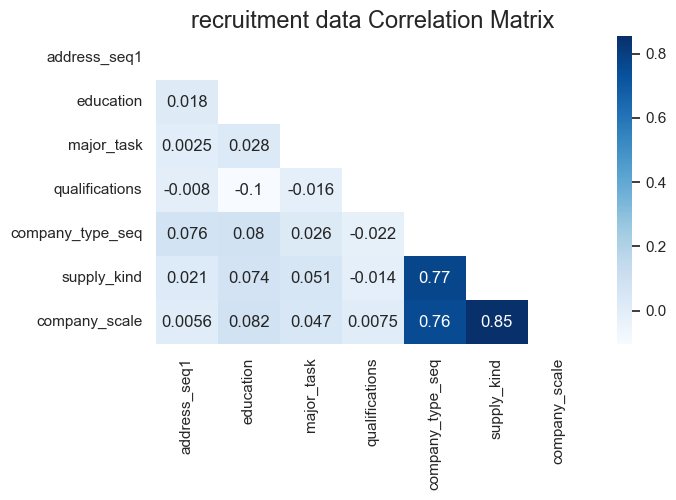

In [212]:
#각 요인들의 상관관계를 나타낸 히트맵
sns.set(style="whitegrid")
mask = np.zeros_like(rec_data.corr())
mask[np.triu_indices_from(mask)] = True
sns.heatmap(rec_data.corr(), annot=True, mask = mask, cmap='Blues', linewidths=0)
fig=plt.gcf()
fig.set_size_inches(7, 4)
plt.title('recruitment data Correlation Matrix', fontsize = 17)
plt.show()

> 분석 결과<br> 
- `company_type_seq(회사유형코드)`와 `supply_kind(주업종코드)`, `company_scale(회사규모분류코드)`의 상관도가 `0.76~0.85`로 상당히 높게 관측되었다. 하지만 이 컬럼들은 `임의의 기준으로 분류한 코드`이므로 상관도가 높더라도 그대로 사용할 것이다.

In [335]:
# 사용하지 않는 컬럼 제거
rec_data.drop(['address_seq2'], axis='columns', inplace=True)

# 수정 데이터 저장
# rec_data.to_csv('./data/pre-processed_data/EDA_rec.csv', encoding='utf-8-sig')

#### * 시각화를 통한 데이터 분석

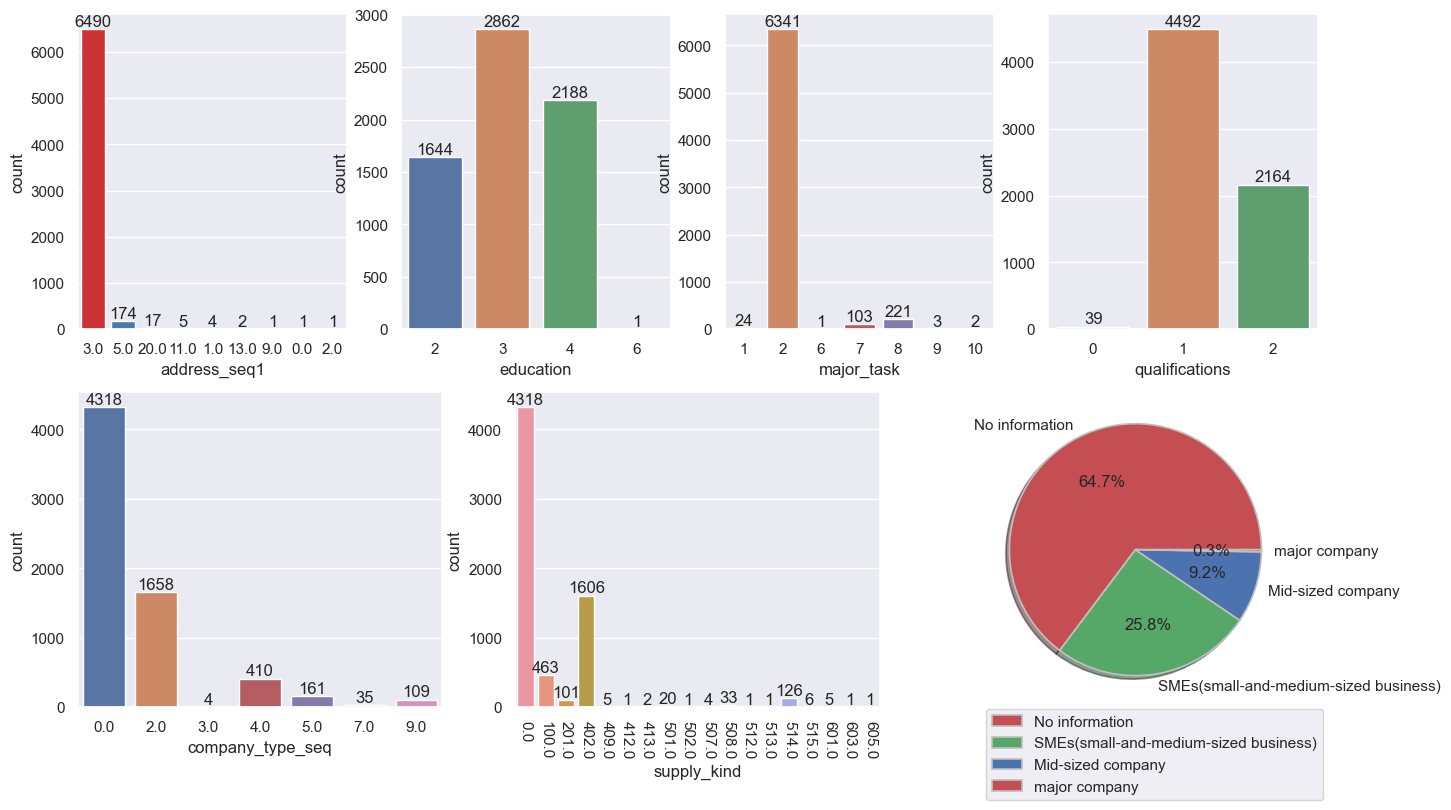

In [316]:
# 그래프로 데이터 분석하기
plt.figure(figsize=(16,9))
sns.set(style="darkgrid")

plt.subplot(2,4,1)
g1 = sns.countplot(data=rec_data, x='address_seq1', order=rec_data.address_seq1.value_counts().index, palette='Set1')
g1.bar_label(g1.containers[0])

plt.subplot(2,4,2)
g2 = sns.countplot(x='education', data=rec_data)
g2.bar_label(g2.containers[0])

plt.subplot(2,4,3)
g3 = sns.countplot(x='major_task', data=rec_data)
g3.bar_label(g3.containers[0])

plt.subplot(2,4,4)
g4 = sns.countplot(x='qualifications', data=rec_data)
g4.bar_label(g4.containers[0])

plt.subplot(2,3,4)
g5 = sns.countplot(x='company_type_seq', data=rec_data)
g5.bar_label(g5.containers[0])

plt.subplot(2,3,5)
g6 = sns.countplot(x='supply_kind', data=rec_data)
g6.bar_label(g6.containers[0])
plt.xticks(rotation = -90)

plt.subplot(2,3,6)
g7 = plt.pie(rec_data.company_scale.value_counts(), wedgeprops={'edgecolor':'silver', 'linewidth':1.2} , colors = 'rgb', labels = ['No information','SMEs(small-and-medium-sized business)','Mid-sized company','major company'], autopct='%1.1f%%', shadow=True)
plt.legend(loc='center left', bbox_to_anchor=(0, -0.15)); print()

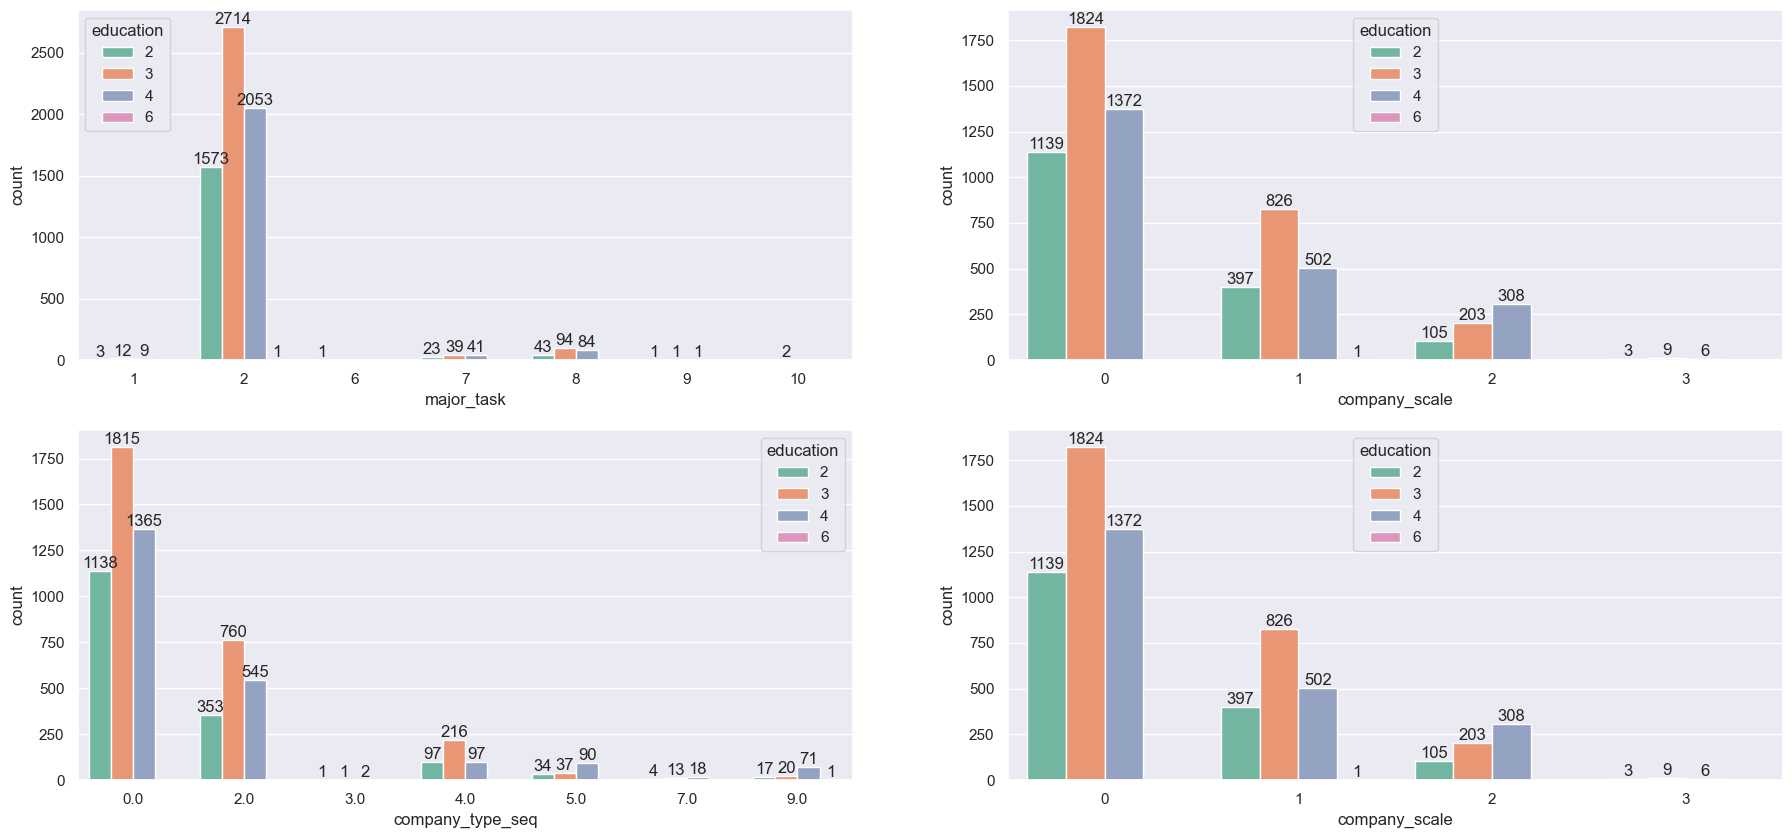

In [257]:
plt.figure(figsize=(22,10))
sns.set_palette('Set2')
plt.subplot(2,2,1)
g1 = sns.countplot(x="major_task", hue="education", data=rec_data)

plt.subplot(2,2,2)
g2 = sns.countplot(x="company_scale", hue="education", data=rec_data)

plt.subplot(2,2,3)
g3 = sns.countplot(x="company_type_seq", hue="education", data=rec_data)

plt.subplot(2,2,4)
g4 = sns.countplot(x="company_scale", hue="education", data=rec_data)

for i in [g1,g2,g3,g4]:
    for bars in i.containers:
        i.bar_label(bars)

## 2.2 구직자 데이터 EDA

In [317]:
# 채용공고 전처리 데이터 로드
res_data = pd.read_csv("./data/pre-processed_data/res_data.csv", index_col=0)

# 결측치 확인
print(', '.join([col for col in res_data.columns if res_data[col].isna().sum() != 0]))

# 데이터 확인
res_data.head(4)

,resume_seq,degree,text_keyword,career_month,career_job_code,job_code_seq,hope_salary_group,univ_type_seq1,univ_type_seq2,univ_major_type,univ_score_group,certificate_list,language_rank
0,U00606,4,스타일디자이너;우븐디자이너,67,없음,i,3,5,5,4,7,없음,9.0
1,U00509,2,상품기획;MD;기획;머천다이저;머천다이징,84,섬유;봉제;가방;의류,i,0,5,5,4,9,없음,9.0
2,U02012,5,니트디자인,121,학교;학원;직원훈련(교육서비스),i,3,5,5,9,9,중등 2급 정교사,9.0
3,U04599,4,MD;기획MD,24,섬유;봉제;가방;의류,i,0,3,5,19,8,MCAS MASTER 2007 / VMD MASTER,5.0


In [318]:
# 전체적인 데이터의 분포 확인하기
print('\033[1m'  + '\033[92m'+ '< numeric data describe >')
display(res_data.describe()); print('\n')
print('\033[1m'  + '\033[92m'+ '< categorical data describe >' + '\033[0m')
display(res_data.describe(include=['O']))

< numeric data describe >


,degree,career_month,hope_salary_group,univ_type_seq1,univ_type_seq2,univ_major_type,univ_score_group,language_rank
count,8482.000000,8482.000000,8482.000000,8482.000000,8482.000000,8482.000000,8482.000000,8482.000000
mean,3.938222,69.408984,1.189342,4.204551,4.684626,8.095143,7.149375,8.619783
std,0.440764,63.547948,1.655792,1.608187,1.892880,5.152574,2.015380,1.322209
min,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,4.000000,18.000000,0.000000,5.000000,5.000000,4.000000,7.000000,9.000000
50%,4.000000,53.000000,0.000000,5.000000,5.000000,9.000000,8.000000,9.000000
75%,4.000000,108.000000,2.000000,5.000000,5.000000,9.000000,8.000000,9.000000
max,6.000000,432.000000,10.000000,6.000000,12.000000,23.000000,10.000000,9.000000




< categorical data describe >


,resume_seq,text_keyword,career_job_code,job_code_seq,certificate_list
count,8482,8482,8482,8482,8482
unique,8482,5296,42,56,2617
top,U00606,매장영업관리,섬유;봉제;가방;의류,i,없음
freq,1,273,5059,7189,2508


> * 특별히 살펴볼 데이터는 없어 컬럼 제거 과정을 거치지 않아도 무방하다 판단.

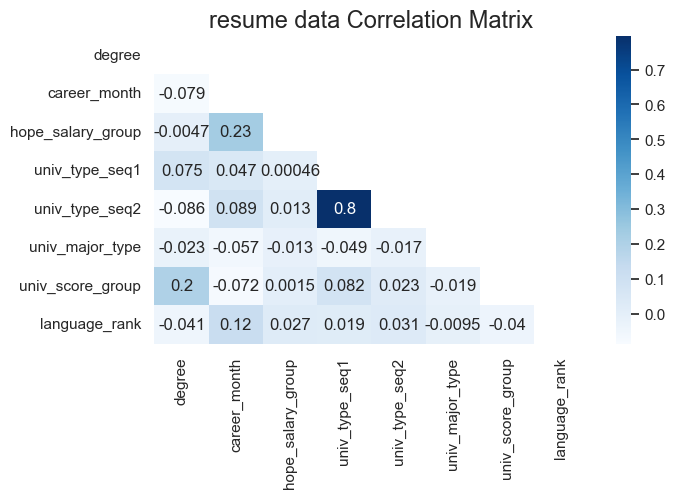

In [319]:
#각 요인들의 상관관계를 나타낸 히트맵
sns.set(style="whitegrid")
mask = np.zeros_like(res_data.corr())
mask[np.triu_indices_from(mask)] = True
sns.heatmap(res_data.corr(), annot=True, mask = mask, cmap='Blues', linewidths=0)
fig=plt.gcf()
fig.set_size_inches(7, 4)
plt.title('resume data Correlation Matrix', fontsize = 17)
plt.show()

In [330]:
# 'univ_type_seq1', 'univ_type_seq2' 비교
print('\033[1m'  + '\033[92m'+ '< univ_type_seq1 data >'+ '\033[0m','\n')
print(list(set(res_data.univ_type_seq1)), res_data.univ_type_seq1.value_counts(), '\n'*2)
print('\033[1m'  + '\033[92m'+ '< univ_type_seq2 data >'+ '\033[0m','\n')
print(list(set(res_data.univ_type_seq2)), res_data.univ_type_seq2.value_counts())

< univ_type_seq1 data > 

[0, 2, 3, 4, 5, 6] 5    6455
3    1006
0     923
4      83
2      13
6       2
Name: univ_type_seq1, dtype: int64 


< univ_type_seq2 data > 

[0, 2, 4, 5, 6, 7, 8, 9, 10, 12] 5     6947
0      923
10     275
6      164
7       99
8       65
4        4
2        2
12       2
9        1
Name: univ_type_seq2, dtype: int64


> 분석 결과<br>
- `univ_type_seq1(최종대학(원)유형코드1)`와 `univ_type_seq2(최종대학(원)유형코드2)`의 상관도가 `0.8`로 상당히 높게 관측되었다. 데이터 확인 결과 'univ_type_seq2'가 더 세세한 분류로 판단되는데, 비슷한 구직자를 찾는 과정에서 너무 세밀하게 분류하면 오히려 추천이 이상하게 될 가능성이 있기 때문에 분류 기준이 더 폭 넓은 `univ_type_seq1(최종대학(원)유형코드1)`을 사용하겠다.

In [338]:
# 사용하지 않는 컬럼 제거
res_data.drop(['univ_type_seq2'], axis='columns', inplace=True)

# 수정 데이터 저장
# res_data.to_csv('./data/pre-processed_data/EDA_res.csv', encoding='utf-8-sig')

#### * 시각화를 통한 데이터 분석

In [339]:
res_data.head(2)

,resume_seq,degree,text_keyword,career_month,career_job_code,job_code_seq,hope_salary_group,univ_type_seq1,univ_major_type,univ_score_group,certificate_list,language_rank
0,U00606,4,스타일디자이너;우븐디자이너,67,없음,i,3,5,4,7,없음,9.0
1,U00509,2,상품기획;MD;기획;머천다이저;머천다이징,84,섬유;봉제;가방;의류,i,0,5,4,9,없음,9.0


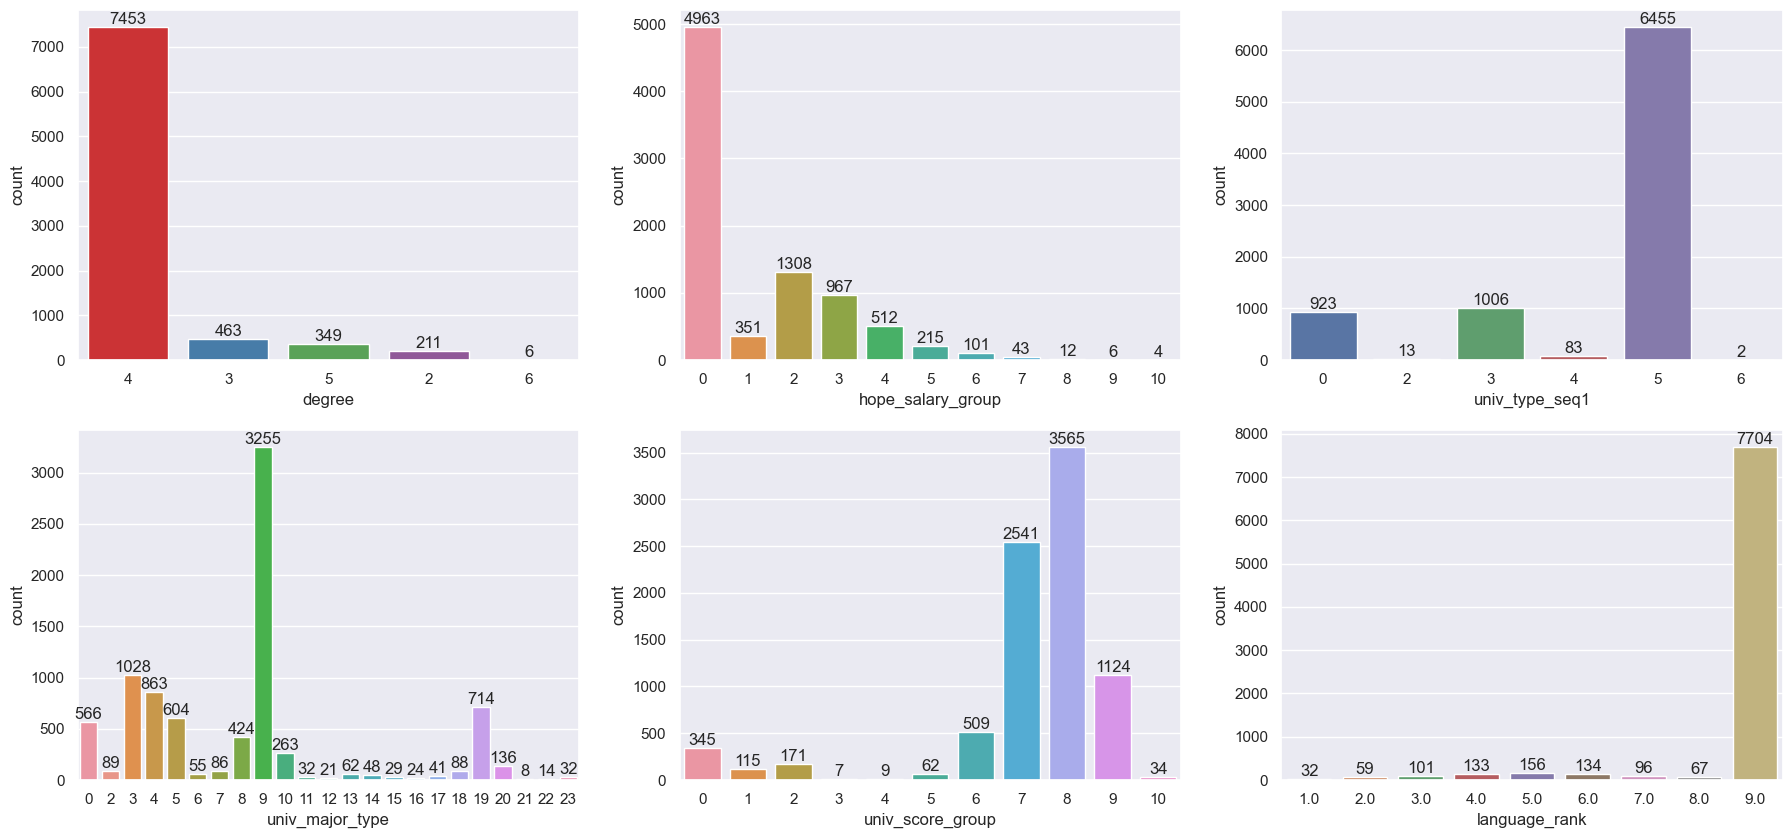

In [345]:
# 그래프로 데이터 분석하기
plt.figure(figsize=(22,10))
sns.set(style="darkgrid")

plt.subplot(2,3,1)
g1 = sns.countplot(data=res_data, x='degree', order=res_data.degree.value_counts().index, palette='Set1')
g1.bar_label(g1.containers[0])

plt.subplot(2,3,2)
g4 = sns.countplot(x='hope_salary_group', data=res_data)
g4.bar_label(g4.containers[0])

plt.subplot(2,3,3)
g5 = sns.countplot(x='univ_type_seq1', data=res_data)
g5.bar_label(g5.containers[0])

plt.subplot(2,3,4)
g6 = sns.countplot(x='univ_major_type', data=res_data)
g6.bar_label(g6.containers[0])
# plt.xticks(rotation = -90)

plt.subplot(2,3,5)
g7 = sns.countplot(x='univ_score_group', data=res_data)
g7.bar_label(g7.containers[0])

plt.subplot(2,3,6)
g8 = sns.countplot(x='language_rank', data=res_data)
g8.bar_label(g8.containers[0]); print()

c:\Users\kimss\anaconda3\lib\site-packages\seaborn\distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


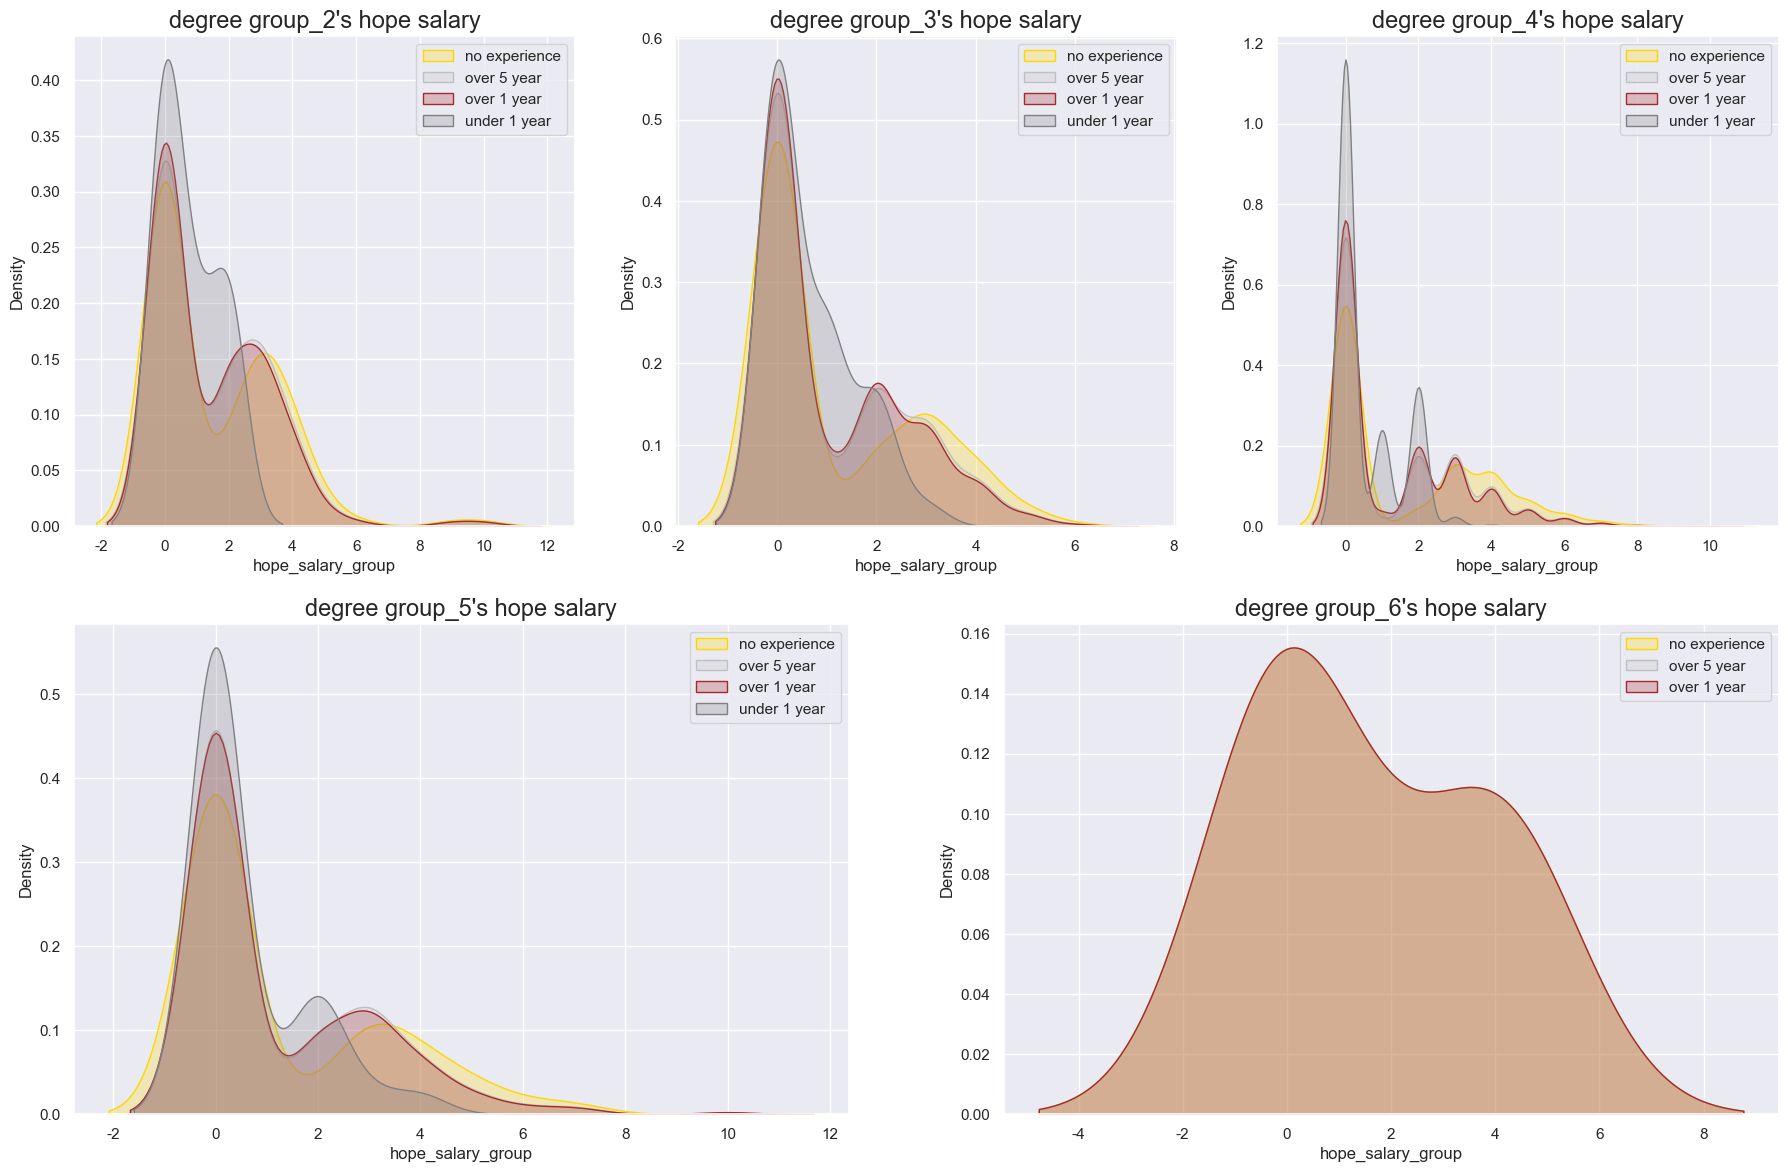

In [375]:
plt.figure(figsize=(22,14))
g1 = plt.subplot(2,3,1)
plt.title(f"degree group_2's hope salary", fontsize = 17)
g2 = plt.subplot(2,3,2)
plt.title(f"degree group_3's hope salary", fontsize = 17)
g3 = plt.subplot(2,3,3)
plt.title(f"degree group_4's hope salary", fontsize = 17)
g4 = plt.subplot(2,2,3)
plt.title(f"degree group_5's hope salary", fontsize = 17)
g5 = plt.subplot(2,2,4)
plt.title(f"degree group_6's hope salary", fontsize = 17)

graph = [0,0,g1,g2,g3,g4,g5]
for i in range(2,7):
    sns.kdeplot(res_data["hope_salary_group"][(res_data["career_month"] > 60) & (res_data['degree'] == i)], 
                ax =graph[i], color="gold", shade= True)
    sns.kdeplot(res_data["hope_salary_group"][(res_data["career_month"] > 12) & (res_data['degree'] == i)], 
                ax =graph[i], color="silver", shade= True)
    sns.kdeplot(res_data["hope_salary_group"][(res_data["career_month"] > 1) & (res_data['degree'] == i)], 
                ax =graph[i], color="brown", shade= True)
    sns.kdeplot(res_data["hope_salary_group"][(res_data["career_month"] == 0) & (res_data['degree'] == i)], 
                ax =graph[i], color="gray", shade= True)
    graph[i].legend(["no experience","over 5 year","over 1 year","under 1 year"])

# 3. 모델링

## 3.1 baseline

### 3.1 baseline (기본)

In [503]:
# 사용자-아이템 행렬 생성: 구직자가 해당 채용 공고에 지원했으면 1, 아니면 0으로 설정
user_item_matrix = apply_train_data.groupby(['resume_seq', 'recruitment_seq']).size().unstack(fill_value=0)
user_item_matrix[user_item_matrix > 1] = 1

# 사용자 간의 유사성 계산
user_similarity = cosine_similarity(user_item_matrix)

# 추천 점수 계산
user_predicted_scores = user_similarity.dot(user_item_matrix) / np.array([np.abs(user_similarity).sum(axis=1)]).T

In [504]:
# 이미 지원한 채용 공고 제외하고 추천
recommendations = []
for idx, user in tqdm(enumerate(user_item_matrix.index)):
    # 해당 사용자가 지원한 채용 공고
    applied_jobs = set(user_item_matrix.loc[user][user_item_matrix.loc[user] == 1].index)
    
    # 해당 사용자의 추천 점수 (높은 점수부터 정렬)
    sorted_job_indices = user_predicted_scores[idx].argsort()[::-1]
    recommended_jobs = [job for job in user_item_matrix.columns[sorted_job_indices] if job not in applied_jobs][:5]
    
    for job in recommended_jobs:
        recommendations.append([user, job])

0it [00:00, ?it/s]

In [509]:
# sample_submission.csv 형태로 DataFrame 생성
top_recommendations = pd.DataFrame(recommendations, columns=['resume_seq', 'recruitment_seq'])
display(top_recommendations)
# top_recommendations.to_csv('./data/result_data/baseline_submit.csv', index=False)

,resume_seq,recruitment_seq
0,U00001,R01528
1,U00001,R03811
2,U00001,R06276
3,U00001,R00165
4,U00001,R02888
...,...,...
42405,U08482,R04602
42406,U08482,R00473
42407,U08482,R00712
42408,U08482,R04021


## 3.2 이력서 전체 컬럼 코사인 유사도 + Nearest Neighbors 모델

In [3]:
# 이력서 데이터와 채용공고 데이터 로드
res_data = pd.read_csv("./data/pre-processed_data/EDA_res.csv", index_col=0)
rec_data = pd.read_csv("./data/pre-processed_data/EDA_rec.csv", index_col=0)

# 결측치 확인
print(', '.join([col for col in res_data.columns if res_data[col].isna().sum() != 0]))
print(', '.join([col for col in rec_data.columns if rec_data[col].isna().sum() != 0]))

In [4]:
# 이력서 새로운 id 부여
resumes = res_data[['resume_seq']]

resumes['new_id'] = 0
for i in range(len(resumes)):
    resumes['new_id'][i] = int(res_data['resume_seq'][i][1:])

# 모든 데이터를 합친 문자열 데이터 입력
resumes['arr'] = ''
for i in range(len(res_data)):
    resumes['arr'][i] = ', '.join(str(i) for i in res_data.loc[i][1:].tolist())

resumes.tail(5)

C:\Users\kimss\AppData\Local\Temp\ipykernel_15824\1138729778.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  resumes['new_id'] = 0
C:\Users\kimss\AppData\Local\Temp\ipykernel_15824\1138729778.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  resumes['new_id'][i] = int(res_data['resume_seq'][i][1:])
C:\Users\kimss\AppData\Local\Temp\ipykernel_15824\1138729778.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

,resume_seq,new_id,arr
8477,U04890,4890,"5, 상품기획;생산;글로벌소싱;남성복;여성복, 204, 섬유;봉제;가방;의류, i,..."
8478,U05910,5910,"4, 소재;기획MD;남성복;온라인MD;디자이너, 12, 섬유;봉제;가방;의류, i,..."
8479,U01468,1468,"4, 상품기획MD;우븐디자인, 0, 섬유;봉제;가방;의류, f, 0, 5, 9, 8..."
8480,U05315,5315,"4, 여성복디자인;우븐디자인;다이마루디자인, 18, 디자인;CAD;설계, i, 0,..."
8481,U01277,1277,"4, 상품기획;머천다이저, 3, 섬유;봉제;가방;의류, i, 2, 5, 5, 8, ..."


In [5]:
# 문자열에 대한 벡터표현 생성
resumes['arr'] = resumes['arr'].apply(lambda x: x.split(','))
model = Word2Vec(resumes['arr'], vector_size=200, window=5, min_count=1, sg=0) # 1 : skip-gram  |  0 : CBOW
resumes['arr_vector'] = resumes['arr'].apply(lambda words: np.mean([model.wv[word] for word in words], axis=0)).tolist()

# arr 컬럼 제거
resumes = resumes.drop(['arr'], axis='columns')

# 확인
resumes.tail(5)

C:\Users\kimss\AppData\Local\Temp\ipykernel_15824\788908878.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  resumes['arr'] = resumes['arr'].apply(lambda x: x.split(','))
C:\Users\kimss\AppData\Local\Temp\ipykernel_15824\788908878.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  resumes['arr_vector'] = resumes['arr'].apply(lambda words: np.mean([model.wv[word] for word in words], axis=0)).tolist()


,resume_seq,new_id,arr_vector
8477,U04890,4890,"[0.07535959, 0.047515426, 0.043908257, 0.29627..."
8478,U05910,5910,"[0.07180746, 0.049141403, 0.03899553, 0.280808..."
8479,U01468,1468,"[0.08417686, 0.0459398, 0.04303865, 0.3155256,..."
8480,U05315,5315,"[0.07071625, 0.052194174, 0.043429807, 0.30806..."
8481,U01277,1277,"[0.08132683, 0.047355175, 0.040151134, 0.29536..."


In [6]:
# 유사도 행렬 계산
similarity_matrix = cosine_similarity(resumes.arr_vector.tolist(), resumes.arr_vector.tolist())

# Nearest Neighbors 모델을 생성
knn = NearestNeighbors(n_neighbors=7, metric='cosine')
knn.fit(similarity_matrix)


# 유사한 구직자가 지원한 공고 찾는 함수
def get_similar_candidates(user_id):
    # 지원자 이력서 id
    user_resume_seq = resumes[resumes.new_id == user_id].resume_seq.to_string()[-6:]

    # 유사도 행렬에서 사용자의 인덱스 가져옴
    user_index = resumes[resumes['resume_seq'] == user_resume_seq].index[0]

    # 유사한 사용자를 찾기
    _, similar_users = knn.kneighbors([similarity_matrix[user_index]], n_neighbors=7)
    similar_user_resume_seq = resumes.iloc[similar_users[0]]['resume_seq'].tolist()

    # 유사한 구직자들이 지원했던 채용 공고 중, 사용자가 지원하지 않았던 채용공고 5개 선택
    similar_resume = []
    for id in similar_user_resume_seq:
        for x in list(apply_train_data[(apply_train_data.resume_seq == id) & ~(apply_train_data.resume_seq == user_resume_seq)].recruitment_seq):
            if x not in similar_resume:
                similar_resume.append(x)
                if len(similar_resume) == 5:
                    return similar_resume

In [7]:
# submission_data 구하기
submission_data = sample_submission_data[['resume_seq']]
submission_data['recruitment_seq'] = ''

for i in tqdm(range(1,8483)):
    # 유사한 구직자가 지원한 채용공고 목록 추출
    submission_data['recruitment_seq'][5*(i-1):5*i] = get_similar_candidates(i)
submission_data

  0%|          | 0/8482 [00:00<?, ?it/s]

,resume_seq,recruitment_seq
0,U00001,R05066
1,U00001,R03251
2,U00001,R00366
3,U00001,R00384
4,U00001,R03996
...,...,...
42405,U08482,R04420
42406,U08482,R01551
42407,U08482,R05507
42408,U08482,R03804


In [13]:
# 중복 확인
arr = []

for i in range(len(submission_data)):
    arr.append(submission_data.resume_seq[i]+submission_data.recruitment_seq[i])

print(f'총 개수: {len(arr)}, 중복 값 제거 후 개수: {len(set(arr))}')

총 개수: 42410, 중복 값 제거 후 개수: 42410


In [22]:
# 완성 데이터 저장
now = datetime.now()
submission_data.to_csv(f'./data/result_data/submission{now.month}{now.day}.csv', index=False , encoding='utf-8-sig')

## 메모

In [4]:
from sklearn.metrics.pairwise import cosine_similarity

# 사용자 및 채용공고 벡터
user_vector = user_data['사용자_벡터'].values[0]
job_ad_vectors = job_ad_data['요구기술_벡터'].to_list()

# 각 채용공고와 사용자 간의 코사인 유사도 계산
similarities = [cosine_similarity([user_vector], [job_vector])[0][0] for job_vector in job_ad_vectors]

# 유사도를 채용공고 데이터프레임에 추가
job_ad_data['유사도'] = similarities

# 유사도에 따라 채용공고 정렬
recommended_job_ads = job_ad_data.sort_values(by='유사도', ascending=False)


NameError: name 'user_data' is not defined

In [5]:
from sklearn.preprocessing import StandardScaler

scaler_resume = StandardScaler()
resumes = scaler_resume.fit_transform(resumes)

NameError: name 'resumes' is not defined

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# 이력서 정보와 고용 공고 데이터
resumes = ["Your resume text here...", ...]
job_postings = ["Job posting text here...", ...]

# TF-IDF 벡터 생성
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(resumes + job_postings)

# 코사인 유사도 계산
cosine_similarities = cosine_similarity(tfidf_matrix, tfidf_matrix)

# 사용자 프로필과 각 고용 공고의 유사성 계산
user_profile = tfidf_matrix[0]  # 예: 첫 번째 이력서를 사용자 프로필로 설정
similarities_to_user = cosine_similarities[0]

# 추천 생성
recommended_jobs = [(job, score) for job, score in enumerate(similarities_to_user[len(resumes):])]
recommended_jobs.sort(key=lambda x: x[1], reverse=True)

AttributeError: 'ellipsis' object has no attribute 'lower'

In [7]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.preprocessing import StandardScaler

# 이력서 정보 데이터를 로드하고 표준화
df = pd.read_csv('이력서데이터.csv')

# 필요한 열 선택 (여러 개의 열을 선택하려면 열 이름을 추가)
selected_columns = ['열1', '열2', '열3', '열4', ...]
df = df[selected_columns]

# 데이터 표준화 (선택적)
from sklearn.preprocessing import StandardScaler
df = StandardScaler().fit_transform(df)

# # 데이터프레임을 NumPy 배열로 변환
# data_array = df.to_numpy()

# 데이터를 각 행별로 평탄화하여 리스트에 저장
data_list = []
for index, row in df.iterrows():
    data_list.append(row)



# 예: X는 이력서 데이터로 구성된 행렬
X = np.array(...)  # 이력서 데이터 배열
X = StandardScaler().fit_transform(X)

# 계층적 클러스터링을 위한 거리 행렬 생성
linkage_matrix = linkage(X, method='ward')

# 덴드로그램 그리기
dendrogram(linkage_matrix, orientation="top", distance_sort='ascending', show_leaf_counts=True)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('이력서 번호')
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '이력서데이터.csv'